In [10]:
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score
from sklearn import metrics
import torch
from torch import nn

from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

In [8]:
h5_file = "./data/test/tf_peaks_TEST_sparse_Remap.h5"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper parameters
num_epochs = 15
batch_size = 128
learning_rate = 0.001

h5_file = "./data/test/tf_peaks_TEST_sparse_Remap.h5"
dataloaders, target_labels, train_out = tools.load_datas(h5_file,
                                                         batch_size,
                                                         0,
                                                         True)

target_labels = [i.decode("utf-8") for i in target_labels]

num_cnns = 100
input_length = 200
num_classes = len(target_labels)
filter_size = 19


model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Dataset Loaded


Epoch [1], Current Train Loss: 0.60184, Current Val Loss: 0.55292
Epoch [2], Current Train Loss: 0.53900, Current Val Loss: 0.53496
Epoch [3], Current Train Loss: 0.52511, Current Val Loss: 0.53269
Epoch [4], Current Train Loss: 0.51661, Current Val Loss: 0.53155
Epoch [5], Current Train Loss: 0.51070, Current Val Loss: 0.53378
Epoch [6], Current Train Loss: 0.50441, Current Val Loss: 0.53491
Epoch [7], Current Train Loss: 0.49895, Current Val Loss: 0.53861
Epoch [8], Current Train Loss: 0.49257, Current Val Loss: 0.54216
Epoch [9], Current Train Loss: 0.48699, Current Val Loss: 0.54513
Epoch [10], Current Train Loss: 0.48186, Current Val Loss: 0.55001
Epoch [11], Current Train Loss: 0.47709, Current Val Loss: 0.55359
Epoch [12], Current Train Loss: 0.47219, Current Val Loss: 0.55531
Epoch [13], Current Train Loss: 0.46744, Current Val Loss: 0.56071
Epoch [14], Current Train Loss: 0.46331, Current Val Loss: 0.56499
Epoch [15], Current Train Loss: 0.45907, Current Val Loss: 0.57074


<Figure size 640x480 with 0 Axes>

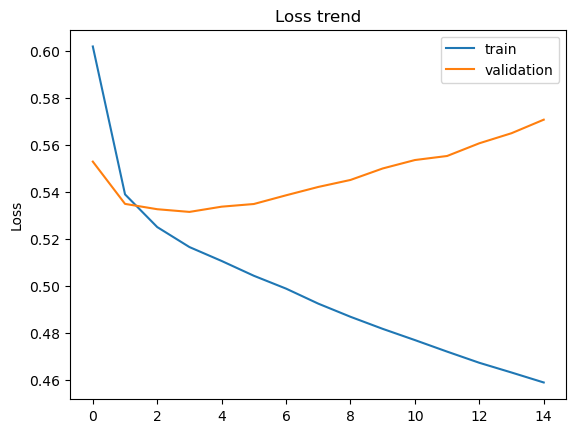

In [4]:
weights_folder = "./data/test/weights"
os.makedirs(weights_folder)

model, train_error, test_error = train.train_explainn(dataloaders["train"],
                                                      dataloaders["valid"],
                                                      model,
                                                      device,
                                                      criterion,
                                                      optimizer,
                                                      num_epochs,
                                                      weights_folder,
                                                      name_ind="",
                                                      verbose=True,
                                                      trim_weights=False,
                                                      checkpoint=0,
                                                      patience=0)

tools.showPlot(train_error, test_error, "Loss trend", "Loss")

In [6]:
model.load_state_dict(torch.load(f"{weights_folder}/{os.listdir(weights_folder)[0]}"))

labels_E, outputs_E = test.run_test(model, dataloaders["test"], device)
pr_rec = average_precision_score(labels_E, outputs_E)

no_skill_probs = [0 for _ in range(len(labels_E[:, 0]))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(labels_E[:, 0], no_skill_probs)

roc_aucs = {}
raw_aucs = {}
roc_prcs = {}
raw_prcs = {}
for i in range(len(target_labels)):
    nn_fpr, nn_tpr, threshold = metrics.roc_curve(labels_E[:, i], outputs_E[:, i])
    roc_auc_nn = metrics.auc(nn_fpr, nn_tpr)

    precision_nn, recall_nn, thresholds = metrics.precision_recall_curve(labels_E[:, i], outputs_E[:, i])
    pr_auc_nn = metrics.auc(recall_nn, precision_nn)

    raw_aucs[target_labels[i]] = nn_fpr, nn_tpr
    roc_aucs[target_labels[i]] = roc_auc_nn

    raw_prcs[target_labels[i]] = recall_nn, precision_nn
    roc_prcs[target_labels[i]] = pr_auc_nn

print(roc_prcs)
print(roc_aucs)

{'MAX': 0.8271612158329784, 'FOXA1': 0.8951556858635922, 'JUND': 0.7568829913124407}
{'MAX': 0.8044346215780999, 'FOXA1': 0.8086684621555142, 'JUND': 0.7482085960437023}


In [21]:
dataset, data_inp, data_out = tools.load_single_data(h5_file,
                                                     batch_size,
                                                     0,
                                                     False)

predictions, labels = interpretation.get_explainn_predictions(dataset,
                                                              model,
                                                              device,
                                                              isSigmoid=True)

# only well predicted sequences
pred_full_round = np.round(predictions)
arr_comp = np.equal(pred_full_round, labels)
idx = np.argwhere(np.sum(arr_comp, axis=1) == len(target_labels)).squeeze()

data_inp = data_inp[idx, :, :]
data_out = data_out[idx, :]

dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)

activations = interpretation.get_explainn_unit_activations(data_loader, model, device)
pwms = interpretation.get_pwms_explainn(activations, data_inp, filter_size)
meme_file = "./data/test/explainn_filters.meme"
interpretation.pwm_to_meme(pwms, meme_file)

100%|████████████████████| 330/330 [00:02<00:00, 154.73it/s]


In [44]:
pwms = interpretation.get_pwms_explainn(activations, data_inp, filter_size)
interpretation.pwm_to_meme(pwms, "./data/test/explainn_filters.meme")

100%|████████████████████| 100/100 [00:15<00:00,  6.61it/s]

Saved PWM File as : ./data/test/explainn_filters.meme


In [46]:
meme_file = "./data/test/explainn_filters.meme"
tomtom_folder = "./data/test/MAX_JUND_FOXA1_tomtom"
jaspar_meme = "./data/JASPAR/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt"
os.system(f"tomtom -oc {tomtom_folder} {meme_file} {jaspar_meme}")

The output directory './data/test/MAX_JUND_FOXA1_tomtom' already exists.
Its contents will be overwritten.
Processing query 1 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.911676
#   Estimated pi_0=0.912805
Processing query 2 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.003
#   Estimated pi_0=1
Processing query 3 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.934918
#   Estimated pi_0=0.934918
Processing query 4 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00435
#   Estimated pi_0=1
Processing query 5 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.0023
#   Estimated pi_0=1


# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995207
#   Estimated pi_0=0.996942
Processing query 47 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997457
#   Estimated pi_0=0.999636
Processing query 48 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00166
#   Estimated pi_0=1
Processing query 49 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995207
#   Estimated pi_0=0.995595
Processing query 50 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00233
#   Estimated pi_0=1
Processing query 51 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating p

# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00094
#   Estimated pi_0=1
Processing query 93 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.979583
#   Estimated pi_0=0.980057
Processing query 94 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994921
#   Estimated pi_0=0.994921
Processing query 95 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00368
#   Estimated pi_0=1
Processing query 96 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998592
#   Estimated pi_0=0.998963
Processing query 97 out of 100 
# Computing q-values.
#   Estimating pi_0 from all 1492 observed p-values.
#   Estimating p

256

In [48]:
tomtom_results = pd.read_table(f"{tomtom_folder}/tomtom.tsv", comment="#")

filters_with_min_q = tomtom_results.groupby("Query_ID").min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

jaspar_motifs = {}
with open(jaspar_meme) as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            jaspar_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([jaspar_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)

In [49]:
weights = model.final.weight.detach().cpu().numpy()

filters = ["filter"+str(i) for i in range(num_cnns)]
for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, index=target_labels, columns=filters)
# focusing on annotated filters only
weight_df = weight_df[[i for i in weight_df.columns if not i.startswith("filter")]]

<Figure size 1500x1000 with 0 Axes>

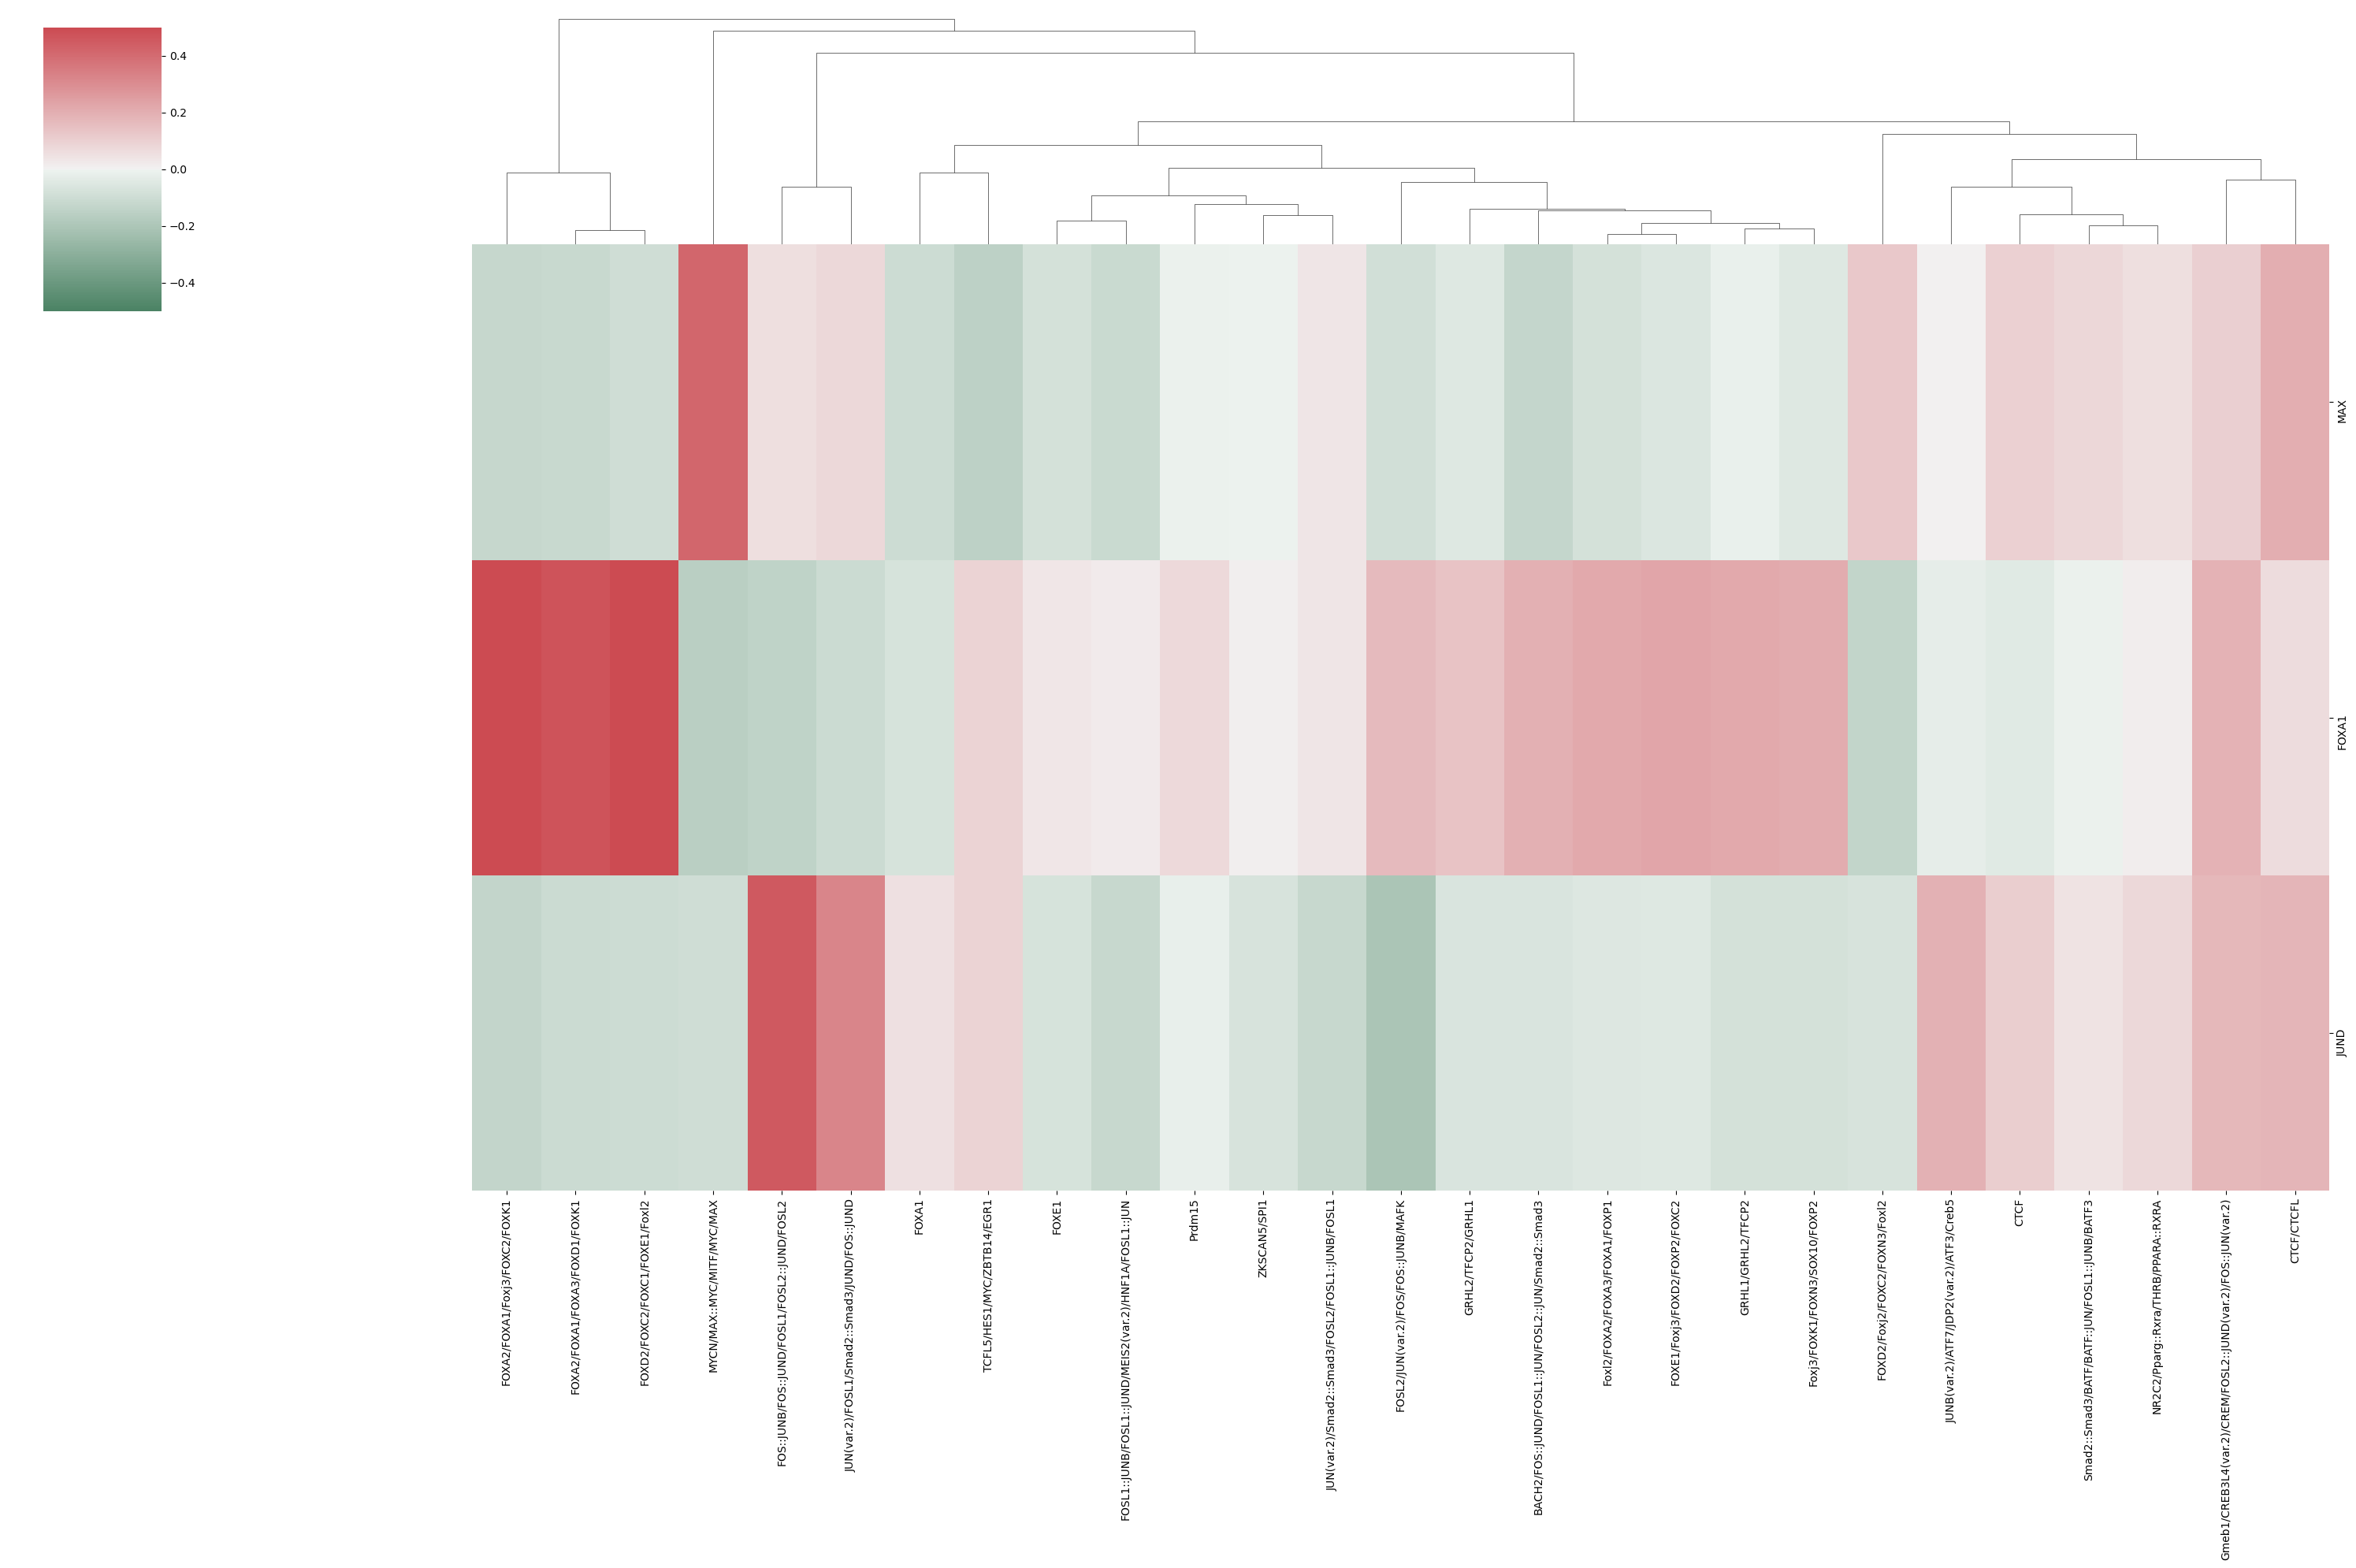

In [50]:
plt.figure(figsize=(15, 10))
sns.clustermap(weight_df,
               cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True),
               row_cluster=False,
               figsize=(30, 20),
               vmax=0.5,
               vmin=-0.5)
plt.show()

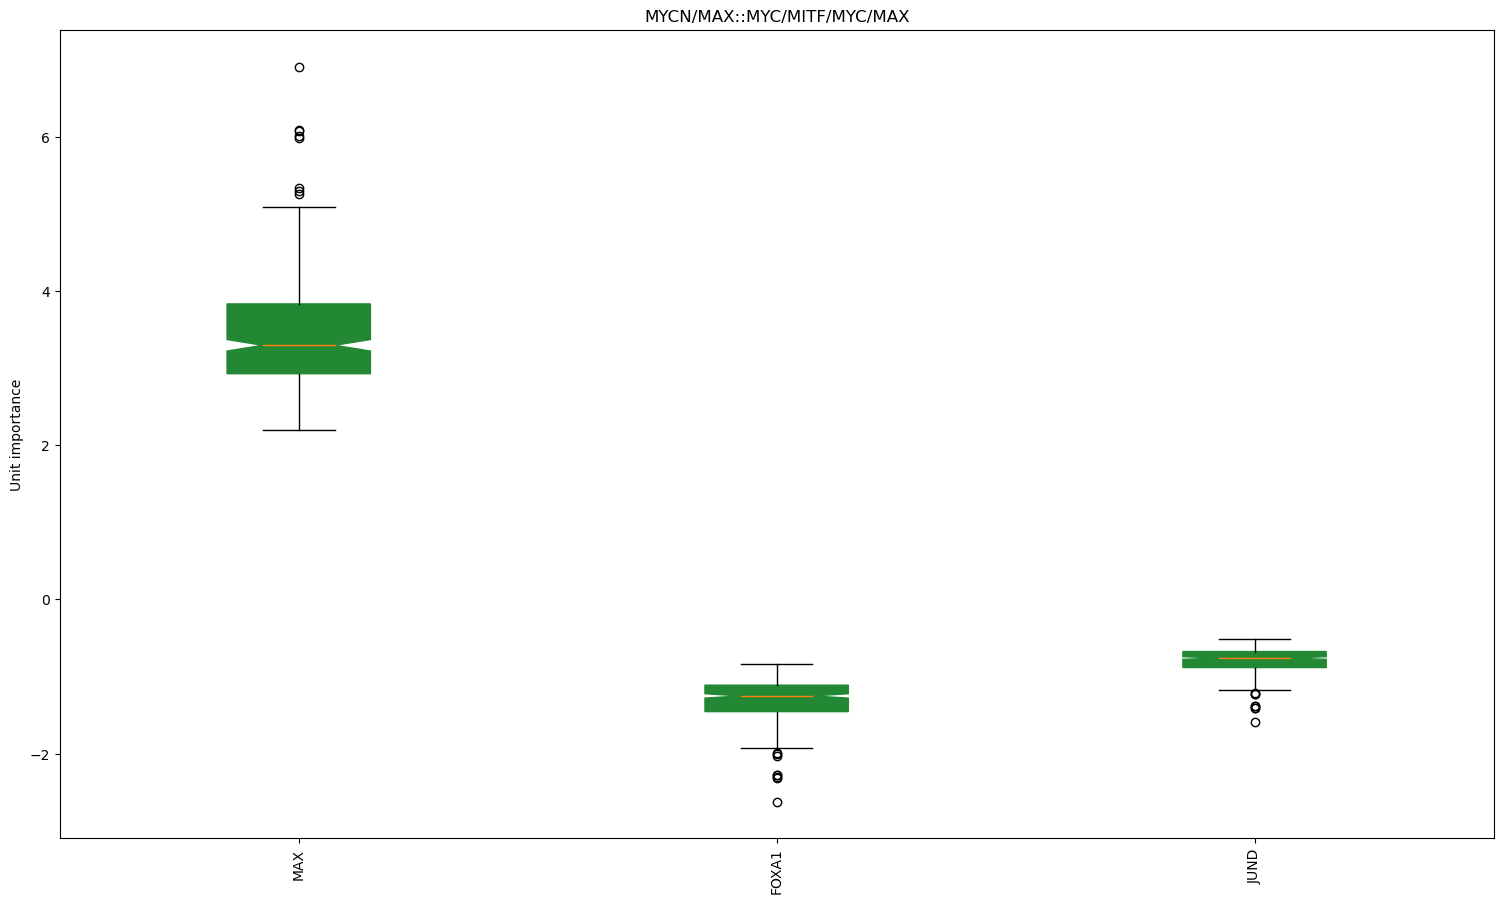

In [57]:
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, model, device)

unit_importance = interpretation.get_specific_unit_importance(activations,
                                                              model,
                                                              unit_outputs,
                                                              57,
                                                              target_labels)

filter_key = "filter"+str(57)
title = annotation[filter_key] if filter_key in annotation.index else filter_key
fig, ax = plt.subplots()
datas = [filt_dat for filt_dat in unit_importance]
ax.boxplot(datas, notch=True, patch_artist=True, boxprops=dict(facecolor="#228833", color="#228833"))
fig.set_size_inches(18.5, 10.5)
plt.title(title)
plt.ylabel("Unit importance")
plt.xticks(range(1, len(target_labels)+1), target_labels)
plt.xticks(rotation=90)
plt.show()